# Demo2

In [1]:
%matplotlib inline
import gc
import time
import fpfs

import numpy as np
import matplotlib.pyplot as plt
import numpy.lib.recfunctions as rfn

## image simulation
+ In this demo we add noise on PSF models. Each PSF has different noise realizations.

SNR is 26.07


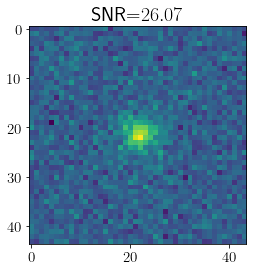

In [2]:
rng     =   np.random.RandomState(212)
testTask=   fpfs.simutil.sim_test(shear=[0,0],rng=rng)
ngrid   =   testTask.img.shape[0]
flux_gal=   np.sum(testTask.img[ngrid//2-2:ngrid//2+3,ngrid//2-2:ngrid//2+3])
noi_std =   3e-3
psf_noi =   6e-4
print('SNR is %.2f' %(flux_gal/(noi_std*5)))
gal,psf= testTask.make_image(noise=noi_std,psf_noise=psf_noi)
plt.close()
plt.imshow(gal)
_=plt.title(r'SNR=$%.2f$'%(flux_gal/(noi_std*5)),fontsize=20)

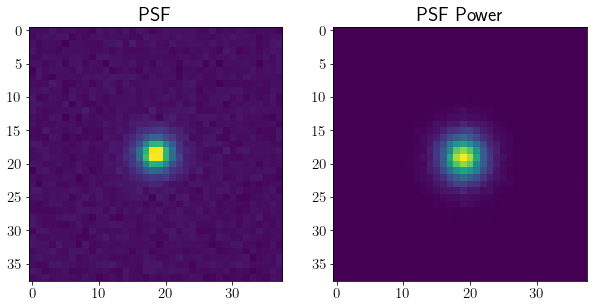

In [3]:
plt.close()
fig=plt.figure(figsize=(10,5))
ax=fig.add_subplot(1,2,1)
ax.imshow(psf)
_=ax.set_title('PSF',fontsize=20)

ax=fig.add_subplot(1,2,2)
ax.imshow(psf)
ax.imshow(fpfs.imgutil.getFouPow(psf))
_=ax.set_title('PSF Power',fontsize=20)

# shear estimation

In [4]:
def analyze_FPFS(rng:np.random.RandomState, input_shear:np.ndarray, num_gals:int,\
        noi_stds,noi_psf=1e-9):
    noi_stds=   np.array(noi_stds)
    if len(noi_stds.shape)==0:
        noi_stds=np.array([noi_stds])
    elif len(noi_stds.shape)>=2:
        raise ValueError('The input noi_stds should be float or 1d list')
    x       =   []      # SNR
    y       =   []      # estimated shear
    y_err   =   []      # error on shear
    # I am calling this task to simulate galaxy images:
    # https://github.com/mr-superonion/FPFS/blob/188ba8679b4db401129e7504ea5126143bafdee4/fpfs/simutil.py#L163
    testTask=   fpfs.simutil.sim_test(shear=input_shear,rng=rng)
    # get an aperture flux for SNR estimation
    ngrid   =   testTask.img.shape[0]
    flux_gal=   np.sum(testTask.img[ngrid//2-2:ngrid//2+3,ngrid//2-2:ngrid//2+3])
    # cutout PSF into postage stamp with width=2rcut
    rcut    =   16
    psf0    =   fpfs.imgutil.cut_img(testTask.psf,rcut)
    gc.collect()
    num_tests=  noi_stds.size
    for i in range(num_tests):
        noii    =   noi_stds[i]
        x.append(flux_gal/(noii*5))
        # initialize FPFS task with an average psf and noise variance (or power spectrum)
        # beta<1 is the FPFS scale parameter
        fpTask  =   fpfs.fpfsBase.fpfsTask(psf0,noiFit=noii**2.,beta=0.75)
        start= time.time()
        results =   []
        for _ in range(num_gals):
            # simulate one galaxy
            gal,psf =   testTask.make_image(noise=noii,psf_noise=noi_psf)
            # cut out psf into 32x32 grids
            psf     =   fpfs.imgutil.cut_img(psf,rcut)
            psfPow  =   fpfs.imgutil.getFouPow(psf,noi_psf**2.)
            # cut out galaxy into 32x32 grids
            gal     =   fpfs.imgutil.cut_img(gal,rcut)
            # FPFS measurement
            modes=  fpTask.measure(gal,psfPow=psfPow)
            # append measured modes to the results list
            results.append(modes)
            del gal,modes,psfPow
        gc.collect()
        end =   time.time()
        print('%.5f seconds to process %d galaxies' %(end-start,num_gals))
        mms =   rfn.stack_arrays(results,usemask=False)
        # set C = std(\delta M_00)
        C   =   np.sqrt(np.average(mms['fpfs_N00N00']))*5.
        ells=   fpfs.fpfsBase.fpfsM2E(mms,const=C,noirev=False)
        del mms,results
        resp=np.average(ells['fpfs_RE'])
        shear=np.average(ells['fpfs_e1'])/resp
        shear_err=np.std(ells['fpfs_e1'])/np.abs(resp)/np.sqrt(num_gals)
        y.append(shear)
        y_err.append(shear_err)
    return np.array(x),np.array(y), np.array(y_err)

In [7]:
rng     =   np.random.RandomState(212)
noi_stds=   np.logspace(-4, -2, 5, base=10.0)
num_gals=   10000
snr,g1,g1err=   analyze_FPFS(rng,np.array([0.03, 0.00]),num_gals,noi_stds,noi_psf=1e-3)

3.77395 seconds to process 10000 galaxies
3.64705 seconds to process 10000 galaxies
3.65751 seconds to process 10000 galaxies
3.66188 seconds to process 10000 galaxies
3.88864 seconds to process 10000 galaxies


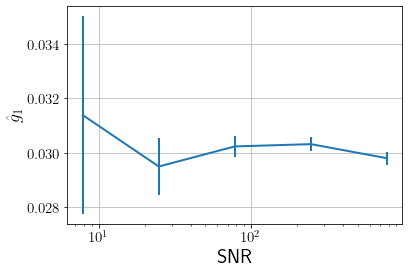

In [8]:
plt.close()
plt.errorbar(snr,g1,g1err)
plt.xlabel('SNR',fontsize=20,weight='bold')
plt.ylabel(r'$\hat{g}_1$')
plt.grid()
plt.xscale('log')